In [2]:
# Core
import pandas as pd
import numpy as np
from scipy.interpolate import CubicSpline

# Astronomy
from astropy.time import Time
from astropy.units import deg

# Utility
import os
from datetime import date
import time
from tqdm.auto import tqdm

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
from IPython.display import Image

# Libraries for getting Alerce data out of ZTF2 database
import json
import psycopg2
from alerce.api import AlerceAPI

# MSE imports
from utils import range_inc
from astro_utils import date_to_mjd, mjd_to_date
from asteroid_integrate import load_data as load_orbital_elts
from ztf_data import load_ztf_det_all, ztf_nearest_ast, ztf_obs_by_month, cdf_nearest_dist
from ztf_data import deg2dist, dist2deg, plot_cdf_uncond, plot_cdf_cond
from asteroid_dataframe import spline_ast_vec_dir

In [3]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

### Load Detections from Alerce ZTF2 Database

In [4]:
ztf, mjd_unq = load_ztf_det_all()

Loaded ../data/ztf/ztf-detections.h5 from disk.


In [5]:
# Review DataFrame
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504
...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241


In [6]:
# Review data types
ztf.dtypes

ObjectID            |S12
CandidateID        int64
TimeStampID        int32
mjd              float64
ra               float64
dec              float64
ux               float64
uy               float64
uz               float64
mag_app          float64
asteroid_prob    float64
dtype: object

In [7]:
# Sanity check: we should be able to recover the mjd of an observation by indexing into mjd_unq
assert np.all(mjd_unq[ztf.TimeStampID] == ztf.mjd)

### Summarize Observations by Month

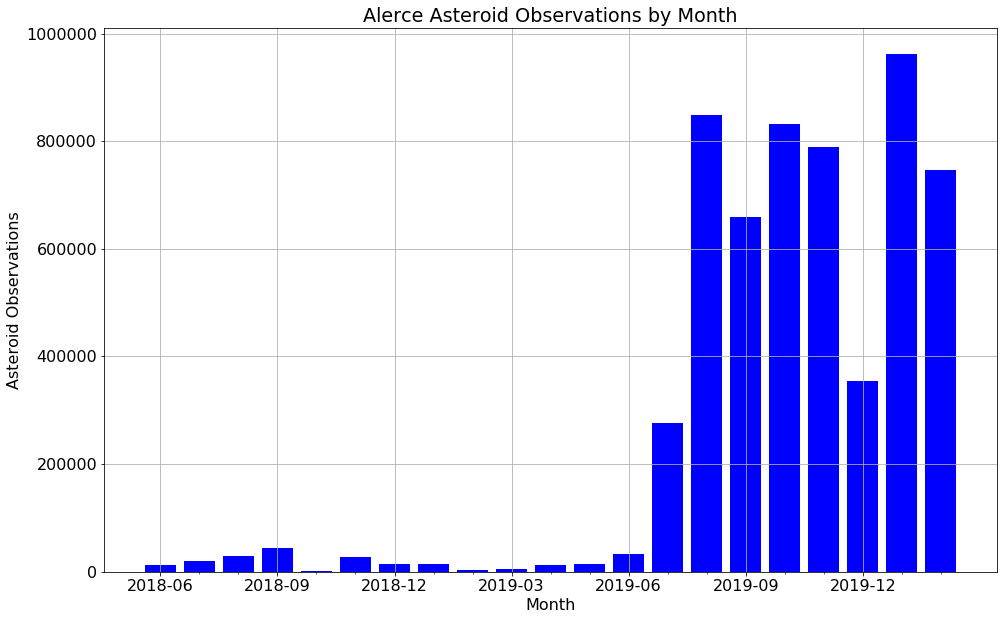

In [8]:
# Generate bar chart
# ztf_obs_by_month(ztf)

# Display the bar chart
Image(filename='../figs/ztf/ztf_ast_per_month.png')

### Extract key Data from ZTF Frame

In [9]:
# Extract mjd, ra, and dec of the ZTF observations as arrays of astropy angles
# mjd_ztf = ztf.mjd.values
# ra_ztf = ztf.ra.values
# dec_ztf = ztf.dec.values

In [10]:
# Extract directions of the ZTF observations as an Nx3 array
# u_ztf = ztf[['ux', 'uy', 'uz']].values

### Load MSE Calculated Asteroid Directions for Comparison to ZTF

In [11]:
# Date range in ZTF data
mjd_min = np.min(mjd_unq)
mjd_max = np.max(mjd_unq)
dt_min = mjd_to_date(mjd_min)
dt_max = mjd_to_date(mjd_max)
print(f'ZTF mjd range : {mjd_min:9.3f} to {mjd_max:9.3f}')
print(f'ZTF date range: {dt_min} to {dt_max}')

ZTF mjd range : 58270.170 to 58905.533
ZTF date range: 2018-06-01 to 2020-02-26


In [12]:
# Range of asteroids to compare to ZTF
n0: int = 0
n1: int = 1000

# Observatory site
# site_name = 'palomar'

In [13]:
# Build splined positions and observations against unique observation times
# ast_pos, earth_pos, ast_dir = spline_ast_vec_dir(n0=n0, n1=n1, mjd=mjd_unq, site_name=site_name)

In [14]:
# Get asteroid numbers in selected range
orb_elt = load_orbital_elts()
ast_mask = (n0 <= orb_elt.Num) & (orb_elt.Num < n1)
ast_nums = orb_elt.Num[ast_mask].values.astype(np.int32)

In [15]:
# Find nearest asteroid to ZTF observations
thresh_deg = 180.0
ztf = ztf_nearest_ast(ztf=ztf, n0=n0, n1=n1, thresh_deg=thresh_deg, regen=False)

Loaded ../data/ztf_ast/ztf-nearest-ast-000000-001000.h5 from disk.


In [16]:
ztf

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,945,0.194089,24.258773,66.943781,0.357053,0.513632,0.780190
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,945,0.240244,38.510983,52.051389,0.481195,0.664986,0.571179
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,945,0.118622,41.742629,60.567169,0.366657,0.646609,0.668925
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,945,0.104112,41.491683,61.609575,0.356157,0.638951,0.681831
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,945,0.148735,41.659926,58.396349,0.391512,0.658374,0.642854
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,164,0.825982,192.132900,30.807833,-0.839705,0.038100,0.541705
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,164,0.634544,192.132817,30.807899,-0.839704,0.038102,0.541706
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,164,0.670675,192.132817,30.807899,-0.839704,0.038102,0.541706
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,2,0.458190,282.460465,7.619587,0.213861,-0.835217,0.506632


### Analyze Distribution of Nearest Asteroid Distance

In [17]:
# Convert threshold from degrees to cartesian distance
# thresh_rad = np.deg2rad(thresh_deg)
# thresh_dist = np.sin(thresh_rad/2.0)*2.0
thresh_close_sec = 10.0
thresh_close_deg = thresh_close_sec / 3600
thresh_dist = deg2dist(thresh_close_deg)

# Count number of asteroids matched against
ast_count = ast_nums.size
# Number of rows in data
N_obs = ztf.shape[0]

# Count frequency of matches
is_close = ztf.nearest_ast_dist < thresh_dist
match_frac_obs = np.mean(is_close)
match_frac_ran = cdf_nearest_dist(dist=thresh_dist, n=ast_count)
match_count_obs = np.sum(is_close)
match_count_ran = N_obs * match_frac_ran
match_ratio = match_frac_obs / match_frac_ran

print(f'Testing {ast_count} asteroids at threshold = {thresh_close_sec} arc sec.')
print(f'Observed match count = {match_count_obs:6d}')
print(f'Random   match count = {match_count_ran:6.0f}')
print(f'Observed match fraction = {match_frac_obs:8.6f}')
print(f'Random   match fraction = {match_frac_ran:8.6f}')
print(f'Ratio =  {match_ratio:8.6f}')

Testing 999 asteroids at threshold = 10.0 arc sec.
Observed match count =  31179
Random   match count =      3
Observed match fraction = 0.005472
Random   match fraction = 0.000001
Ratio =  9321.537459


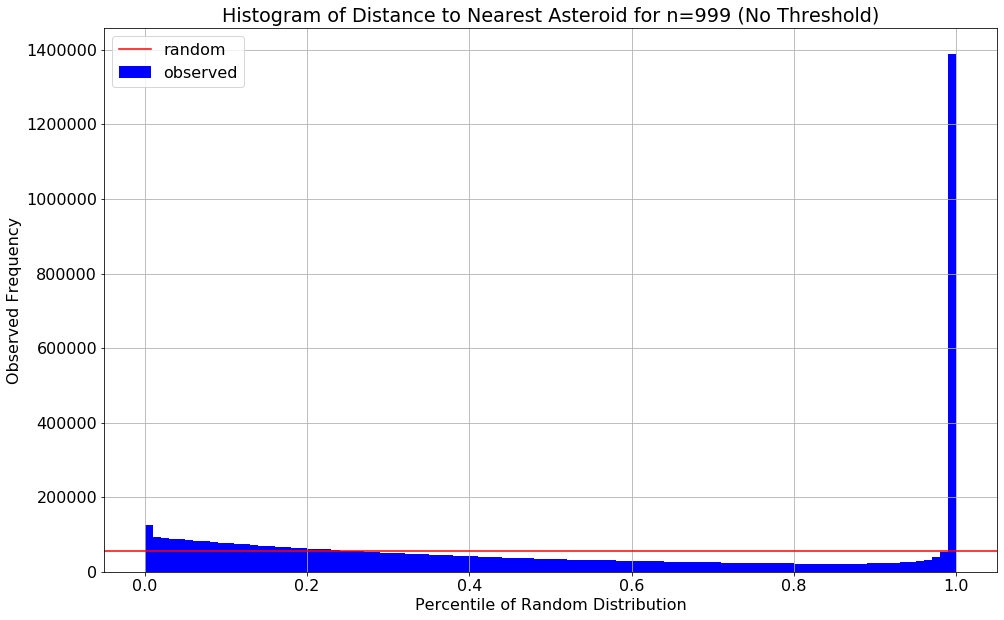

In [18]:
# Plot the unconditional distribution
fig, ax = plot_cdf_uncond(ztf=ztf, n=ast_count, bins=100)

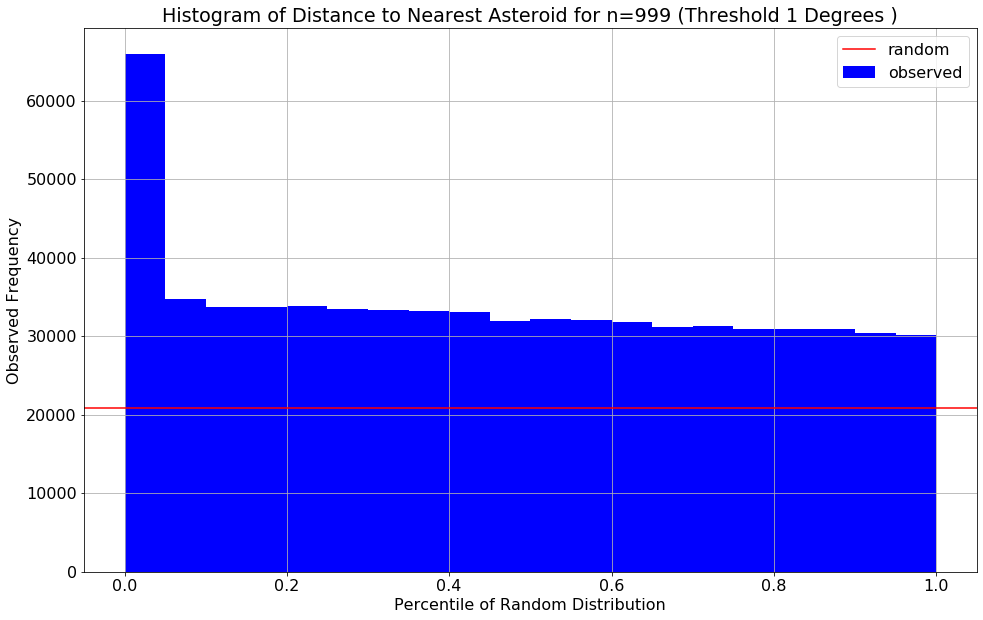

In [19]:
# Plot the conditional distribution at a threshold of 1.0 degrees
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=1.0, bins=20)

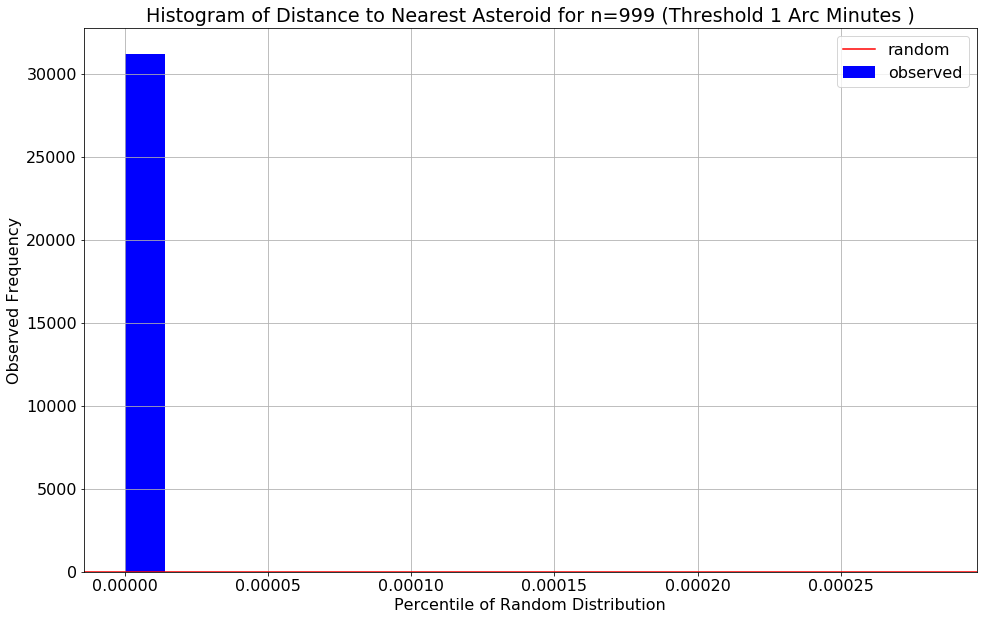

In [20]:
# Plot the conditional distribution at a threshold of 1 arc minute
thresh_one_min = 1.0 / 60
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_one_min, bins=20)

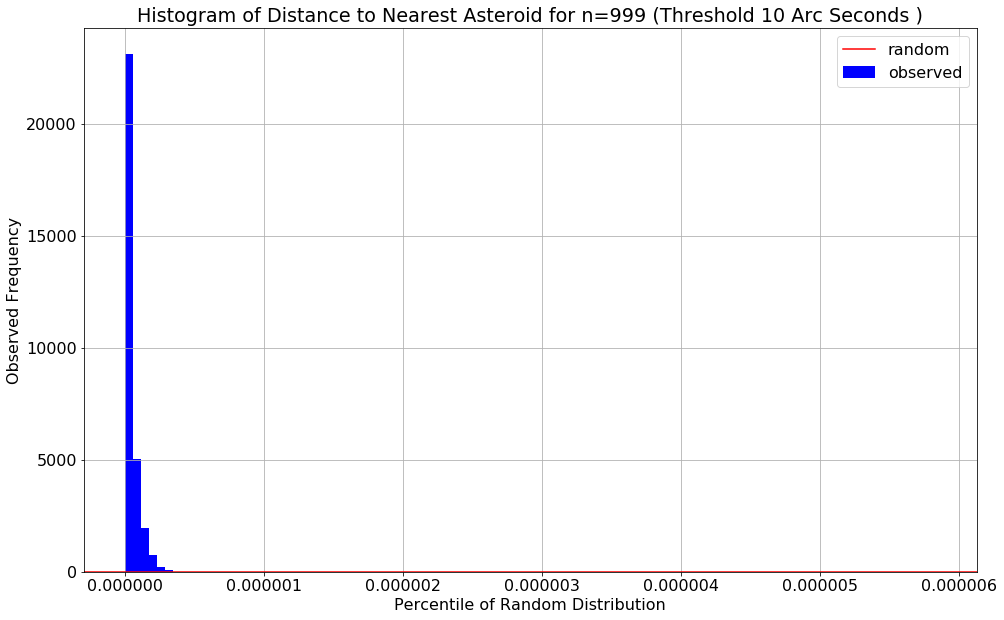

In [21]:
# Plot the conditional distribution at a threshold of 10 arc seconds
thresh_ten_sec = 10.0 / 3600
fig, ax = plot_cdf_cond(ztf=ztf, n=ast_count, thresh_deg=thresh_ten_sec, bins=100)

### Explore Observations that are Close to One Asteroid

In [22]:
thresh_sec_close = 10
thresh_deg_close = thresh_sec_close / 3600
thresh_dist_close = deg2dist(thresh_deg_close)
print(f'Threshold to be close:')
print(f'{thresh_sec_close} arc seconds')
print(f'{thresh_dist_close:6.2e} cartesian distance')

is_close = ztf.nearest_ast_dist < thresh_dist_close

Threshold to be close:
10 arc seconds
4.85e-05 cartesian distance


In [23]:
ztf1k = ztf[is_close].copy()
ztf1k

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
10059,b'ZTF18abtmgks',612417811215015007,7863,58366.417813,355.881165,-12.029493,0.975514,-0.147354,-0.163274,14.818800,0.976651,782,0.000004,355.881390,-12.029368,0.975515,-0.147350,-0.163274
108994,b'ZTF18acvbkyo',710241791315015010,18526,58464.241794,48.434838,16.509191,0.636119,0.771198,-0.024628,13.780000,1.000000,447,0.000003,48.434993,16.509192,0.636117,0.771199,-0.024628
141458,b'ZTF18acebqjy',674327526215015023,14011,58428.327523,79.996310,28.562455,0.152570,0.983754,0.094609,13.874900,1.000000,536,0.000002,79.996433,28.562368,0.152569,0.983754,0.094607
3606,b'ZTF19aacspig',739244130915015031,22466,58493.244132,123.664605,30.804990,-0.476123,0.859591,0.185499,13.078600,1.000000,469,0.000003,123.664800,30.804979,-0.476125,0.859590,0.185500
420,b'ZTF19aadpomx',749151882415015010,22991,58503.151887,12.013435,3.760860,0.975992,0.216646,-0.022436,16.584600,1.000000,718,0.000003,12.013270,3.760809,0.975993,0.216643,-0.022435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5458461,b'ZTF20aareiae',1151312393215015013,97084,58905.312396,180.945431,-1.377819,-0.999575,-0.024699,-0.015499,16.295900,1.000000,239,0.000002,180.945563,-1.377869,-0.999575,-0.024701,-0.015499
5458875,b'ZTF20aareozu',1151522390115015010,97090,58905.522396,236.791550,-5.363014,-0.545289,-0.801460,0.245604,16.714001,1.000000,652,0.000002,236.791413,-5.362975,-0.545291,-0.801459,0.245604
5458886,b'ZTF20aarepii',1151522393415015017,97090,58905.522396,236.892710,-2.341055,-0.545753,-0.784135,0.295442,15.089800,1.000000,727,0.000002,236.892569,-2.341034,-0.545755,-0.784134,0.295442
5458889,b'ZTF20aareowa',1151522390315015003,97090,58905.522396,237.654792,-5.909325,-0.532176,-0.811960,0.239813,15.717300,1.000000,625,0.000002,237.654657,-5.909328,-0.532178,-0.811958,0.239813


In [24]:
# Group results by asteroid number
close_by_ast = ztf1k.groupby(ztf1k.nearest_ast_num)
close_by_ast_count = close_by_ast.size()
close_ast_num = close_by_ast_count.index.values
close_ast_count = close_by_ast_count.values

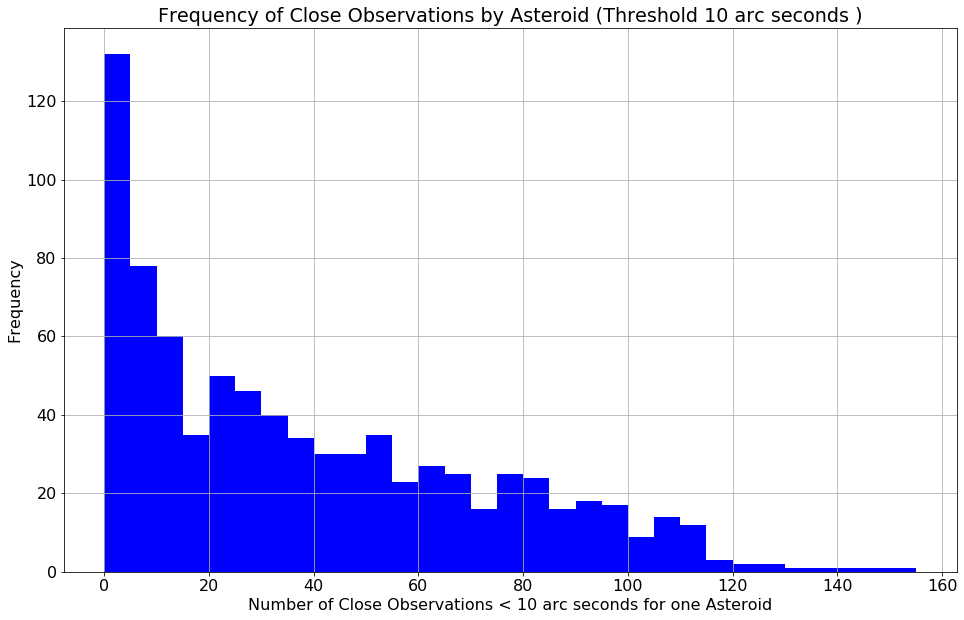

In [25]:
# Set up bins
bin_size = 5
bin_max = np.max(close_ast_count) + bin_size
bins = np.arange(0, bin_max, bin_size)

fig, ax = plt.subplots()
thresh_caption = f'{thresh_sec_close} arc seconds'
ax.set_title(f'Frequency of Close Observations by Asteroid (Threshold {thresh_caption} )')
ax.set_xlabel(f'Number of Close Observations < {thresh_caption} for one Asteroid')
ax.set_ylabel('Frequency')
freq, bins_np, patches = ax.hist(x=close_ast_count, bins=bins, color='blue')
bin_count = bins_np.size - 1
# random_freq = N_obs * prob_close/ bin_count
# ax.axhline(y=random_freq, color='red', label='random')
# ax.legend()
ax.grid()
fig.savefig(f'../figs/ztf/close_obs_per_ast_hist.png', bbox_inches='tight')
plt.show()

In [26]:
np.sum(close_ast_count >= 20)

503

In [27]:
ztf2 = ztf_nearest_ast(ztf=ztf, n0=1000, n1=2000)

Loaded ../data/ztf_ast/ztf-nearest-ast-001000-002000.h5 from disk.


In [28]:
ztf2.columns

Index(['ObjectID', 'CandidateID', 'TimeStampID', 'mjd', 'ra', 'dec', 'ux',
       'uy', 'uz', 'mag_app', 'asteroid_prob', 'nearest_ast_num',
       'nearest_ast_dist', 'ast_ra', 'ast_dec', 'ast_ux', 'ast_uy', 'ast_uz'],
      dtype='object')

In [29]:
np.max(ztf2.nearest_ast_num)

2000

In [30]:
ztf2

,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,ux,uy,uz,mag_app,asteroid_prob,nearest_ast_num,nearest_ast_dist,ast_ra,ast_dec,ast_ux,ast_uy,ast_uz
0,b'ZTF18acebhfp',676397301515010013,14490,58430.397303,41.357345,58.879488,0.387942,0.653853,0.649598,18.946699,0.865682,1981,0.319273,4.813677,60.023489,0.497883,0.383035,0.778073
1,b'ZTF18abodmwk',596403415715010014,5831,58350.403414,30.969721,65.305308,0.358224,0.558644,0.748059,19.010401,0.855504,1981,0.458340,55.527008,42.638579,0.416386,0.825857,0.380241
2,b'ZTF18abodmwk',626428345715010011,10614,58380.428345,30.969705,65.305294,0.358224,0.558644,0.748059,18.935900,0.855504,1981,0.213319,49.630538,56.894036,0.353774,0.714997,0.603012
3,b'ZTF18abodmwk',630507595715015045,11250,58384.507593,30.969940,65.305305,0.358223,0.558645,0.748059,19.260401,0.855504,1981,0.177319,47.196102,58.508537,0.354947,0.690822,0.629903
4,b'ZTF18abodmwk',618384965715010022,9040,58372.384965,30.969643,65.305179,0.358226,0.558644,0.748058,19.220200,0.855504,1981,0.282726,53.065693,53.359703,0.358610,0.756841,0.546435
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5459014,b'ZTF20aareruw',1151532523515015015,97109,58905.532523,253.007910,55.485537,-0.165587,-0.169403,0.971537,19.192400,0.608023,1901,0.821873,228.260474,10.993201,-0.653529,-0.596190,0.466323
5459015,b'ZTF20aarerwx',1151533002615015009,97110,58905.533009,232.886408,53.509617,-0.358833,-0.115301,0.926253,19.687099,0.559474,1362,0.721167,196.378534,21.557324,-0.892309,-0.094461,0.441432
5459016,b'ZTF20aarerww',1151533002115010003,97110,58905.533009,236.167899,54.618457,-0.322375,-0.116973,0.939357,19.957001,0.392662,1901,0.750381,228.260512,10.993241,-0.653528,-0.596190,0.466324
5459017,b'ZTF20aarervr',1151526063515015015,97098,58905.526065,286.235286,33.876902,0.232120,-0.509626,0.828494,19.049299,0.517241,1922,0.613434,310.887916,6.382248,0.650525,-0.645093,0.400841


In [32]:
orb_elt

,Num,Name,epoch_mjd,a,e,inc,Omega,omega,M,H,G,Ref,f,P,n,long,theta,pomega,T_peri
Num,,,,,,,,,,,,,,,,,,,
1,1,Ceres,58600.0,2.769165,0.076009,0.184901,1.401596,1.284522,1.350398,3.34,0.12,JPL 46,1.501306,1683.145749,0.003733,4.036516,4.187424,2.686118,-361.745873
2,2,Pallas,58600.0,2.772466,0.230337,0.608007,3.020817,5.411373,1.041946,4.13,0.11,JPL 35,1.490912,1686.155979,0.003726,3.190951,3.639917,2.149005,-279.616804
3,3,Juno,58600.0,2.669150,0.256942,0.226699,2.964490,4.330836,0.609557,5.33,0.32,JPL 108,0.996719,1592.787270,0.003945,1.621697,2.008860,1.012141,-154.522558
4,4,Vesta,58600.0,2.361418,0.088721,0.124647,1.811840,2.630709,1.673106,3.20,0.32,JPL 34,-4.436417,1325.432768,0.004740,6.115656,0.006132,4.442550,-352.940421
5,5,Astraea,58600.0,2.574249,0.191095,0.093672,2.470978,6.260280,4.928221,6.85,0.15,JPL 108,-1.738676,1508.600442,0.004165,1.093108,0.709396,2.448072,325.328481
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1255499,1255499,2019 QG,58600.0,0.822197,0.237862,0.220677,5.066979,3.770460,0.503214,21.55,0.15,JPL 1,0.807024,272.309165,0.023074,-3.225717,-2.921908,-3.728932,-21.808984
1255501,1255501,2019 QL,58600.0,2.722045,0.530676,0.113833,4.741919,2.351059,5.297173,19.21,0.15,JPL 1,-2.082964,1640.368337,0.003830,-0.176219,-1.273172,0.809793,257.420824
1255502,1255502,2019 QQ,58600.0,1.053137,0.389091,0.172121,5.648270,2.028352,3.266522,25.31,0.15,JPL 1,-3.081905,394.753268,0.015917,-1.623227,-1.688469,1.393436,189.527723


In [33]:
block_size = 5000

In [36]:
ast_nums = orb_elt.Num.values.astype(np.int32)
ast_nums

array([      1,       2,       3, ..., 1255502, 1255513, 1255514],
      dtype=int32)

In [37]:
ast_nums.size

733489

In [38]:
block_nums = np.unique(ast_nums // block_size)
block_nums

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 200, 201, 202, 203, 204, 205, 206, 207,
       208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220,
       221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233,
       234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246,
       247, 248, 249, 250, 251], dtype=int32)

In [43]:
import multiprocessing
from multiprocessing import Pool

In [44]:
multiprocessing.cpu_count()

80

In [45]:
block_nums.size

161

In [46]:
len(block_nums)

161

In [48]:
pool = Pool(1)

In [49]:
pool.map(x=x)

NameError: name 'x' is not defined